In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn import preprocessing
import sklearn.linear_model as sklm
import sklearn.model_selection as skms
import solution
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.metrics import log_loss

In [2]:
sns.set()

In [3]:
data = pd.read_csv('dataset.csv', sep=';')
data

,ShotType,Competition,PlayerType,Transition,TwoLegged,Movement,Angle,Distance
0,above head,U14,F,1,1,no,73.83,0.73
1,layup,U14,F,0,1,no,28.13,1.02
2,above head,U14,F,0,1,no,51.88,7.22
3,above head,U14,F,1,1,no,80.84,3.64
4,above head,U14,F,0,1,no,30.89,7.20
...,...,...,...,...,...,...,...,...
5019,layup,EURO,C,0,1,no,0.00,0.52
5020,above head,EURO,C,0,1,no,60.91,4.29
5021,hook shot,EURO,C,0,1,no,26.86,0.83
5022,above head,EURO,C,0,1,no,3.42,5.38


In [4]:
one_hot = pd.get_dummies(data[["Competition", "PlayerType", "Movement"]], drop_first=True)
data = pd.concat([data, one_hot], axis=1)
data = data.drop(["Competition", "PlayerType", "Movement"], axis=1)

In [5]:
data["Transition"] = data["Transition"].astype(bool)
data["TwoLegged"] = data["TwoLegged"].astype(bool)

In [6]:
data.dtypes

ShotType             object
Transition             bool
TwoLegged              bool
Angle               float64
Distance            float64
Competition_NBA        bool
Competition_SLO1       bool
Competition_U14        bool
Competition_U16        bool
PlayerType_F           bool
PlayerType_G           bool
Movement_drive         bool
Movement_no            bool
dtype: object

In [7]:
column_names = data.columns[1:]
shot_types = np.unique(data["ShotType"])

In [8]:
data["ShotType"] = data["ShotType"].astype("category")
data["ShotType"] = data["ShotType"].cat.codes

In [9]:
X_train, X_test, y_train, y_test = skms.train_test_split(data.drop(labels="ShotType", axis='columns'), data["ShotType"], test_size=0.2, random_state=42)

In [10]:
#scale the data

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)



In [11]:
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(int)
y_test = y_test.astype(int)


In [12]:
l = solution.MultinomialLogReg()
l.build(X_train, y_train)



In [13]:
def lower_upper(X, y, num_bootstrap = 100, alpha = 0.05):
    coef_samples = np.zeros((  num_bootstrap, X.shape[1]+1, len(np.unique(y))))

    l = solution.MultinomialLogReg()
    for i in range(num_bootstrap):
        print(i)
        X_train, y_train = resample(X, y, replace=True)
        l.build(X_train, y_train)
        coef_samples[i, :, :] = l.coefficients
        print(coef_samples[i, :, :])
    
    return coef_samples

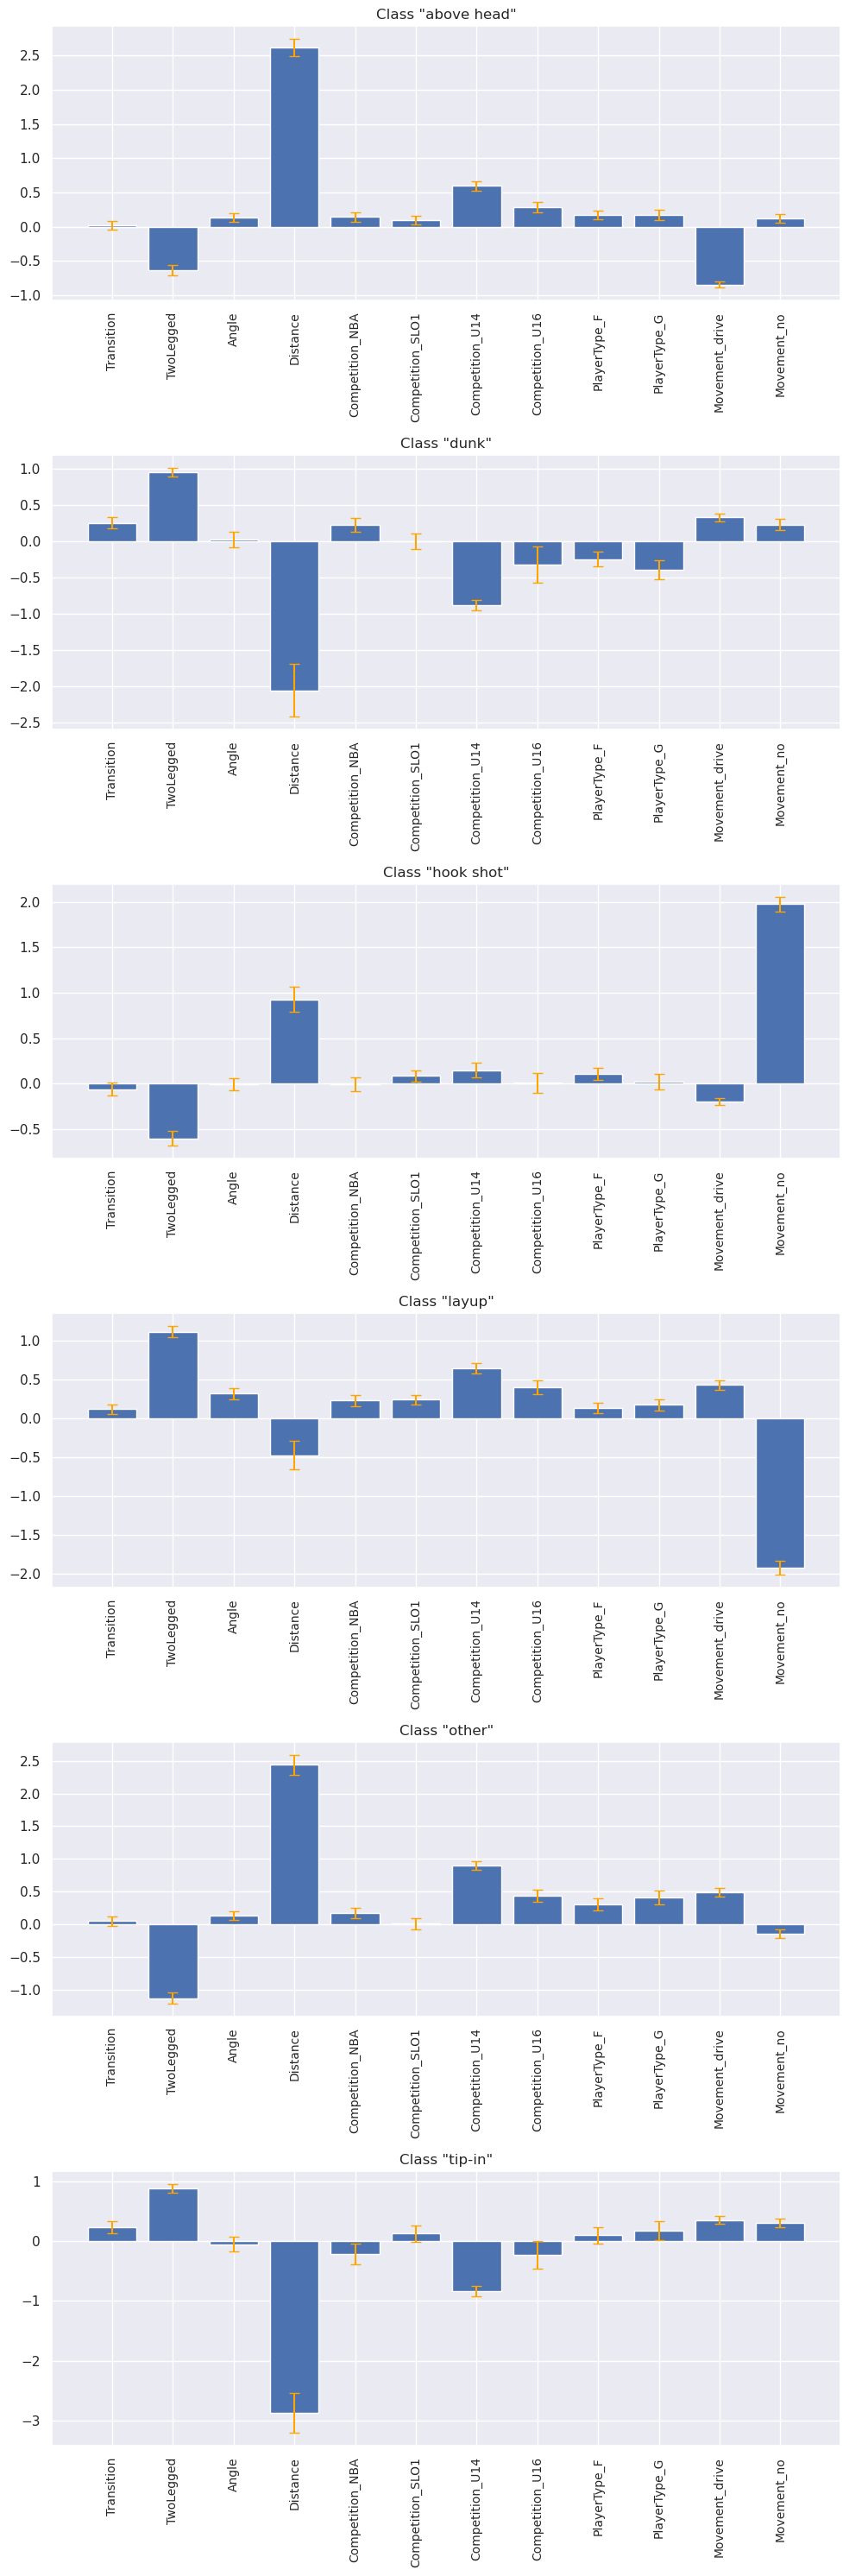

In [14]:
# coefs = lower_upper(X_train, y_train) 

coefs = np.loadtxt("coefs.csv", delimiter=",")
shape = np.loadtxt("shape.txt", delimiter=",")
coefs = coefs.reshape(shape.astype(int))
means = np.mean(coefs[:, 1:, :], axis=0)
sds = np.std(coefs[:, 1:, :], axis=0)

fig, ax = plt.subplots(len(np.unique(y_train)), 1, figsize=(10, 30))

for i in range(len(np.unique(y_train))):
    ax[i].bar(np.arange(means.shape[0]), means[:, i])
    ax[i].errorbar(np.arange(means.shape[0]), means[:, i], yerr=sds[ :, i], fmt='none', capsize=4, ecolor = 'orange')
    ax[i].set_title(f"Class \"{shot_types[i]}\"")
    ax[i].set_xticks(np.arange(means.shape[0]))
    ax[i].set_xticklabels(column_names, rotation=90, size= 10)

plt.tight_layout()
# plt.savefig("report/figures/coefficients.pdf")

In [16]:
l_scikit = sklm.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
l_scikit.fit(X_train, y_train)


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [17]:
preds = l.predict(X_test)
preds = np.argmax(preds, axis=1)
preds = preds == y_test
preds

1504     True
538      True
4989     True
4949     True
4820     True
        ...  
2244     True
1592     True
4655    False
3973     True
150     False
Name: ShotType, Length: 1005, dtype: bool

In [18]:
preds_scikit = l_scikit.predict(X_test)
preds_scikit = preds_scikit == y_test
preds_scikit

1504     True
538      True
4989     True
4949     True
4820     True
        ...  
2244     True
1592     True
4655    False
3973     True
150     False
Name: ShotType, Length: 1005, dtype: bool

In [19]:
accuracy = np.mean(preds)
accuracy

0.7383084577114428

In [20]:
accuracy_scikit = np.mean(preds_scikit)
accuracy_scikit

0.7393034825870647

In [26]:
MBOG_TRAIN = 50

def multinomial_bad_ordinal_good(n):
    X = np.random.normal(loc= 0, scale=1, size=(n, 12))
    y = np.random.randint(0, 3, size=n)

    return X, y


In [27]:
X, y = multinomial_bad_ordinal_good(MBOG_TRAIN)
X_test, y_test = multinomial_bad_ordinal_good(1000)

l = solution.MultinomialLogReg()
l.build(X, y)

pred = l.predict(X_test)
# pred = np.argmax(pred, axis=1)

13


In [29]:

o = solution.OrdinalLogReg()
o.build(X, y)
pred_o = o.predict(X_test)

l_loss = log_loss(y_test, l.predict(X_test))
o_loss = log_loss(y_test, o.predict(X_test))

print(l_loss, o_loss)

(1.7084235465825106, 1.4331031900374998)

In [30]:
#accuracy
pred = np.argmax(pred, axis=1)
pred_o = np.argmax(pred_o, axis=1)

accuracy = np.mean(pred == y_test)
print(accuracy)

accuracy_o = np.mean(pred_o == y_test)
print(accuracy_o)


0.323
0.339
